# Data Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import statsmodels.api as sm

We start by importing all the relevant datasets, including the main dataset that was provided by our advisor. It contains data on Stack Overflow activity by NUTS3 region over the years.

In [2]:
# Load the main dataset
dataFileName = os.path.join("Data", "stackoecdmatch_Nova.dta")
SO_activity = pd.read_stata(dataFileName)
SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP_Y15_64_,EMP_Y15_MAX_,GVA_CURR_PR_,GVA_REAL_PPP_,GVA_REAL_PR_,GVA_USD_PPP_,POP_T
0,2009.0,,,0.0,0.0,53.0,4.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010.0,,,3.0,4.0,287.0,10.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011.0,,,2.0,11.0,964.0,18.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012.0,,,0.0,6.0,920.0,33.0,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013.0,,,0.0,0.0,1825.0,103.0,556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Basic Data Cleaning

In [3]:
# Convert 'year' columnn from float to integer
SO_activity['year'] = SO_activity['year'].astype(int)
SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP_Y15_64_,EMP_Y15_MAX_,GVA_CURR_PR_,GVA_REAL_PPP_,GVA_REAL_PR_,GVA_USD_PPP_,POP_T
0,2009,,,0.0,0.0,53.0,4.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,,,3.0,4.0,287.0,10.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011,,,2.0,11.0,964.0,18.0,240.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012,,,0.0,6.0,920.0,33.0,405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,,,0.0,0.0,1825.0,103.0,556.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Replace empty strings with NaN in the 'country' column
SO_activity['country'].replace('', np.nan, inplace=True)

# Drop rows where the 'country' column is empty (NaN)
SO_activity.dropna(subset=['country'], inplace=True)

SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP_Y15_64_,EMP_Y15_MAX_,GVA_CURR_PR_,GVA_REAL_PPP_,GVA_REAL_PR_,GVA_USD_PPP_,POP_T
13,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,296000.0,NaN,NaN,NaN,NaN,NaN
14,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,543685.0
15,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,550298.0
16,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,555782.0
17,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,560674.0


When checking for NaN values we can see that there are a lot of missing values for the socio-economic factors. For employment we have more than 50% of the values missing:

In [5]:
SO_activity.shape

(8426, 15)

In [6]:
SO_activity.isnull().sum()

year                0
nuts3_name          0
country             0
questioncount       0
answercount         0
upvotecount         0
downvotecount       0
commentcount        0
EMP_Y15_64_      5051
EMP_Y15_MAX_     3848
GVA_CURR_PR_     2305
GVA_REAL_PPP_    2305
GVA_REAL_PR_     2305
GVA_USD_PPP_     2305
POP_T             506
dtype: int64

We drop the existing economic factors due to the many missing values. Also, we were not sure where the data came from and how those factors were defined (probably OECD data). Therefore, we decided to define the indicators that we want to use ourselves and find meaningful data from Eurostats and other sources that represents those indicators. 

In the end, the goal is to handle any kind of missing values in order to ensure that our future models perform well.

In [7]:
# Drop the columns with the economic factors
SO_activity = SO_activity.iloc[:, :8]

SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount
13,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0
14,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0
15,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0
16,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0
17,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0


## Merging Economic Factors

In order to join the main dataset with the Eurostats data, we need an identifier that ensures that the values are merged correctly. For this, we can use the NUTS3 names that we have in the main dataset. 

However, the Eurostats data uses NUTS3 codes to identify the different regions. Therefore, we first had to match our NUTS3 regions with the corresponding codes. We used the official Excel sheet provided by Eurostats that maps the regions to their codes.

We realized that some of the region names in the main dataset differ from the names in the Eurostats dataset. We identified those differences and compiled a mapping file called **Nuts3 Correction** that helps us link both files without losing data:

| **StackOverflow Activity Name** | **Eurostats Name** |
|--------------------------------|-------------------|
| Bern                           | Bern / Berne      |
| Fribourg (CH)                  | Fribourg / Freiburg |
| Graubünden                     | Graubünden / Grigioni / Grischun |
| Jura (CH)                      | Jura              |
| Lucerne                        | Luzern            |
| Valais                         | Valais / Wallis   |
| Alicante                       | Alicante/Alacant  |
| Balearic Islands               | Mallorca (assumed main island for Balearic Islands) |
| Biscay                         | Bizkaia           |
| Castellón                      | Castellón/Castelló |
| Córdoba (ES)                   | Córdoba           |
| Gerona                         | Girona            |
| La Corunna                     | A Coruña          |
| Lérida                         | Lleida            |
| Navarre                        | Navarra           |
| Orense                         | Ourense           |
| Saragossa                      | Zaragoza          |
| Seville                        | Sevilla           |
| Valencia                       | Valencia/València |
| Aosta Valley                   | Valle d’Aosta/Vallée d’Aoste |
| Florence                       | Firenze           |
| Genoa                          | Genova            |
| L'Aquila                       | L’Aquila          |
| Mantua                         | Mantova           |
| Milan                          | Milano            |
| Naples                         | Napoli            |
| Padua                          | Padova            |
| Reggio nell'Emilia             | Reggio nell’Emilia |
| Rome                           | Roma              |
| Turin                          | Torino            |
| Venice                         | Venezia           |
| Blekinge County                | Blekinge län      |
| Dalarna County                 | Dalarnas län      |
| Gotland County                 | Gotlands län      |
| Gävleborg County               | Gävleborgs län    |
| Halland County                 | Hallands län      |
| Jämtland County                | Jämtlands län     |
| Jönköping County               | Jönköpings län    |
| Kalmar County                  | Kalmar län        |
| Kronoberg County               | Kronobergs län    |
| Norrbottens County             | Norrbottens län   |
| Skåne County                   | Skåne län         |
| Stockholm County               | Stockholms län    |
| Södermanland County            | Södermanlands län |
| Uppsala County                 | Uppsala län       |
| Värmlands County               | Värmlands län     |
| Västerbottens County           | Västerbottens län |
| Västernorrland County          | Västernorrlands län |
| Västmanland County             | Västmanlands län  |
| Västra Götaland County         | Västra Götalands län |
| Örebro County                  | Örebro län        |
| Östergötland County            | Östergötlands län |
| Adiyaman                       | Adıyaman          |
| Afyon                          | Afyonkarahisar    |
| Agri                           | Ağrı              |
| Aydin                          | Aydın             |
| Balikesir                      | Balıkesir         |
| Bartin                         | Bartın            |
| Diyarbakir                     | Diyarbakır        |
| Elazig                         | Elazığ            |
| Eskisehir                      | Eskişehir         |
| Gümüshane                      | Gümüşhane         |
| Igdir                          | Iğdır             |
| Istanbul                       | İstanbul          |
| Izmir                          | İzmir             |
| Kahramanmaras                  | Kahramanmaraş     |
| Kirikkale                      | Kırıkkale         |
| Kirklareli                     | Kırklareli        |
| Kirsehir                       | Kırşehir          |
| Mugla                          | Muğla             |
| Mus                            | Muş               |
| Nevsehir                       | Nevşehir          |
| Nigde                          | Niğde             |
| Sanliurfa                      | Şanlıurfa         |
| Sirnak                         | Şırnak            |
| Tekirdag                       | Tekirdağ          |
| Usak                           | Uşak              |
| Çankiri                        | Çankırı           |


In [8]:
# Load the excel file that maps the nuts3_name from the SO data with the nuts3_codes in Eurostats data
dataFileName2 = os.path.join("Data", "Nuts3 Correction.xlsx")

# Read the Excel file
nuts3_codes_df = pd.read_excel(dataFileName2)

# Display the first few rows
nuts3_codes_df.head()

,Country Code,Country,nuts3_name,NUTS level 3,Code 2021
0,TR,Turkey,Adiyaman,Adıyaman,TRC12
1,TR,Turkey,Afyon,Afyonkarahisar,TR332
2,TR,Turkey,Agri,Ağrı,TRA21
3,IT,Italy,Aosta Valley,Valle d’Aosta/Vallée d’Aoste,ITC20
4,TR,Turkey,Aydin,Aydın,TR321


In [9]:
# Merge both files to visualize each region and its corresponding nuts3_code including the SO data
SO_activity= pd.merge(SO_activity, nuts3_codes_df[['nuts3_name', 'Code 2021']], on='nuts3_name', how='left')
SO_activity.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,Code 2021
0,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
1,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
2,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
3,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033
4,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033


In [10]:
# Verify that there are no missing values
SO_activity.isna().sum()

year             0
nuts3_name       0
country          0
questioncount    0
answercount      0
upvotecount      0
downvotecount    0
commentcount     0
Code 2021        0
dtype: int64

As mentioned before, there was insuficient data in the given dataset. We opted to search for the indicators.

Source: [EUROSTATS](https://inserlinkhere)

In [11]:
# Merge of all the Eurostats data

# Define the columns to read from each file
emp_cols = ['geo', 'TIME_PERIOD', 'EMP']
gdp_cols = ['geo', 'TIME_PERIOD', 'GDP', 'unit']
gva_cols = ['geo', 'TIME_PERIOD', 'GVA', 'unit']
pop_cols = ['geo', 'TIME_PERIOD', 'POP']

# Read the files with only necessary columns
emp_df = pd.read_csv("Data/eurostats_emp.csv", usecols=emp_cols)
gdp_df = pd.read_csv("Data/eurostats_gdp.csv", usecols=gdp_cols)
gva_df = pd.read_csv("Data/eurostats_gva.csv", usecols=gva_cols)
pop_df = pd.read_csv("Data/eurostats_pop.csv", usecols=pop_cols)

# Rename columns to include unit names
emp_df.rename(columns={'EMP': 'EMP (THS)'}, inplace=True)
pop_df.rename(columns={'POP': 'POP (THS)'}, inplace=True)

# Pivot the GDP dataframe to reshape it
gdp_pivoted = gdp_df.pivot(index=['geo', 'TIME_PERIOD'], columns='unit', values='GDP').reset_index()
gdp_pivoted.columns = ['geo', 'TIME_PERIOD'] + [f'GDP ({unit})' for unit in gdp_pivoted.columns[2:]]

# Pivot the GVA dataframe to reshape it
gva_pivoted = gva_df.pivot(index=['geo', 'TIME_PERIOD'], columns='unit', values='GVA').reset_index()
gva_pivoted.columns = ['geo', 'TIME_PERIOD'] + [f'GVA ({unit})' for unit in gva_pivoted.columns[2:]]

# Merge all dataframes on 'geo' and 'TIME_PERIOD'
indicators_df = (emp_df
             .merge(gdp_pivoted, on=['geo', 'TIME_PERIOD'], how='outer')
             .merge(gva_pivoted, on=['geo', 'TIME_PERIOD'], how='outer')
             .merge(pop_df, on=['geo', 'TIME_PERIOD'], how='outer'))

# Rename columns to 'nuts3_code' and 'time_period' for consistency
indicators_df.rename(columns={'geo': 'nuts3_code', 'TIME_PERIOD': 'time_period'}, inplace=True)

indicators_df.head()

,nuts3_code,time_period,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,ES111,2000,383.1,12700.0,69.0,13951.74,13951.74,15663.53,14300.0,78.0,12684.1,12684.1,1095.6
1,ES111,2001,405.7,13600.0,71.0,14954.83,14954.83,16556.08,15100.0,79.0,13634.8,13634.8,1095.7
2,ES111,2002,419.7,14800.0,75.0,16303.34,16303.34,18000.97,16400.0,83.0,14861.5,14861.5,1098.0
3,ES111,2003,436.9,15800.0,78.0,17458.37,17458.37,18876.71,17100.0,84.0,15839.7,15839.7,1102.3
4,ES111,2004,446.4,17000.0,80.0,18803.37,18803.37,20057.08,18100.0,86.0,16964.2,16964.2,1106.6


In [12]:
# Save the merged dataframe to an Excel file
indicators_df.to_excel("INDICATORS.xlsx", index=False)

In [13]:
# Rename columns for merging
indicators_df.rename(columns={'time_period': 'year'}, inplace=True)
SO_activity.rename(columns={'Code 2021': 'nuts3_code'}, inplace=True)

# Merge the two dataframes
merged_df = pd.merge(SO_activity, indicators_df , on=['nuts3_code', 'year'], how='left')

merged_df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2000,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,Aargau,CH,0.0,0.0,0.0,0.0,0.0,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Check for missing values
merged_df.isna().sum()

year                          0
nuts3_name                    0
country                       0
questioncount                 0
answercount                   0
upvotecount                   0
downvotecount                 0
commentcount                  0
nuts3_code                    0
EMP (THS)                  2536
GDP (EUR_HAB)               948
GDP (EUR_HAB_EU27_2020)     948
GDP (MIO_EUR)               870
GDP (MIO_NAC)               870
GDP (MIO_PPS_EU27_2020)     870
GDP (PPS_EU27_2020_HAB)     948
GDP (PPS_HAB_EU27_2020)     948
GVA (MIO_EUR)               870
GVA (MIO_NAC)               870
POP (THS)                   922
dtype: int64

There are still quite a lot of missing values for the economic factors. We decided to check what time period would make sense for us to use. For this, we plot the Stack Overflow activity over the years because our future analysis depends on the activity. If we have no data on that for certain years, we can drop them.

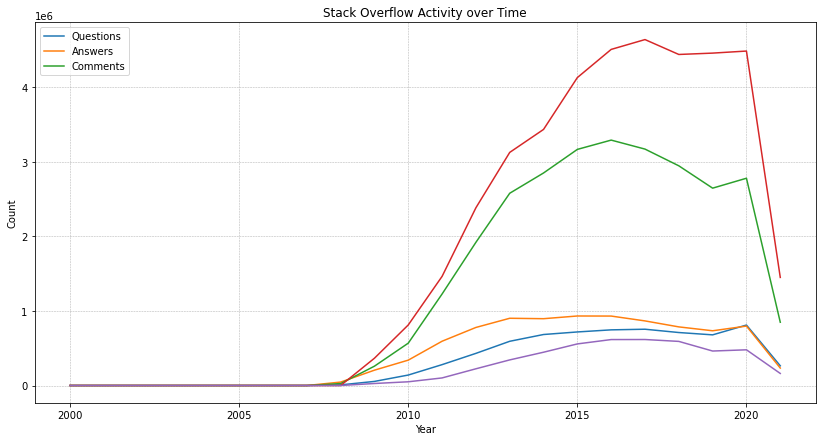

In [15]:
# Plot the SO activity over time
SO_activity_over_time = SO_activity.groupby('year')[['questioncount', 'answercount', 'commentcount', 'upvotecount', 'downvotecount']].sum()
SO_activity_over_time.plot(kind='line', figsize=(14, 7))
plt.title('Stack Overflow Activity over Time')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(['Questions', 'Answers', 'Comments'])
plt.show()

We can see that there is no data before 2008 and that there is a big dropoff in 2021, which indicates that the data was collected during that year and therefore doesn't include all of the data for 2021.

Let's make sure there are no Stack Overflow activity values before 2008:

In [16]:
merged_df[merged_df.year < 2008][['questioncount', 'answercount', 'upvotecount', 'downvotecount', 'commentcount']].sum()

questioncount    0.0
answercount      0.0
upvotecount      0.0
downvotecount    0.0
commentcount     0.0
dtype: float64

In [17]:
# Drop all the values that are not in the timeframe of 2008-2020
merged_df = merged_df[(merged_df.year>2007) & (merged_df.year<2021)]

In [18]:
# Save the final dataframe to an Excel file
merged_df.to_excel("FINAL.xlsx", index=False)

In [19]:
# Read the final datset
final_df = pd.read_excel(r"FINAL.xlsx")

This is a list of the columns in our final dataset and the corresponding description:

| Column                      | Description                                               |
|-----------------------------|-----------------------------------------------------------|
| **nuts3_code**              | NUTS 3 region code                                        |
| **year**             | Time period for the data                                  |
| **EMP (THS)**               | Employment in thousands for the region                    |
| **GDP (EUR_HAB)**           | GDP per inhabitant in euros                               |
| **GDP (EUR_HAB_EU27_2020)** | GDP per inhabitant in euros (indexed to EU27_2020)        |
| **GDP (MIO_EUR)**           | GDP in million euros                                      |
| **GDP (MIO_NAC)**           | GDP in million units of national currency                 |
| **GDP (MIO_PPS_EU27_2020)** | GDP in million Purchasing Power Standards (EU27_2020)     |
| **GDP (PPS_EU27_2020_HAB)** | GDP per inhabitant in PPS (EU27_2020)                     |
| **GDP (PPS_HAB_EU27_2020)** | GDP per inhabitant in PPS (indexed to EU27_2020)          |
| **GVA (MIO_EUR)**           | Gross Value Added in million euros                        |
| **GVA (MIO_NAC)**           | Gross Value Added in million units of national currency   |
| **POP (THS)**               | Population in thousands                                   |
| **nuts3_name**              | Name of the NUTS 3 region                                 |
| **country**                 | Country the NUTS 3 region belongs to                      |
| **questioncount**           | Number of questions posted from the region on StackOverflow|
| **answercount**             | Number of answers provided from the region on StackOverflow|
| **upvotecount**             | Number of upvotes received for the region on StackOverflow |
| **downvotecount**           | Number of downvotes received for the region on StackOverflow|
| **commentcount**            | Number of comments made from the region on StackOverflow  |


In [20]:
final_df

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,NaN,NaN,NaN,31791.60,39186.33,20892.36,NaN,NaN,30948.00,38146.50,NaN
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,NaN,NaN,NaN,32721.27,39438.95,21505.74,NaN,NaN,31921.08,38474.47,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.0,41000.0,145.0,18408.07,174304.19,13722.47,30600.0,108.0,16305.80,154398.00,449.00
5001,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.0,41300.0,141.0,18787.46,181019.09,14044.57,30900.0,105.0,16657.12,160493.00,454.99
5002,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.0,41000.0,135.0,18855.66,193427.07,14793.54,32200.0,106.0,16710.18,171418.00,460.01
5003,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.0,40600.0,130.0,18820.58,199292.98,15097.04,32500.0,104.0,16714.73,176994.00,464.00


## Handling Missing Data

In [21]:
import warnings
warnings.filterwarnings('ignore')

# List of the indicators
indicators = [
    'EMP (THS)',
    'GDP (EUR_HAB)',
    'GDP (EUR_HAB_EU27_2020)',
    'GDP (MIO_EUR)',
    'GDP (MIO_NAC)',
    'GDP (MIO_PPS_EU27_2020)',
    'GDP (PPS_EU27_2020_HAB)',
    'GDP (PPS_HAB_EU27_2020)',
    'GVA (MIO_EUR)',
    'GVA (MIO_NAC)',
    'POP (THS)',
    'questioncount',
    'answercount',
    'upvotecount',
    'downvotecount',
    'commentcount'
]

# Create a DataFrame to hold the count data
data_counts_df = pd.DataFrame(columns=['Indicator', 'NaN Count', 'Zero Count', 'Data Count', 'Total'])

# Populate the DataFrame with counts for each indicator
for indicator in indicators:
    nan_count = final_df[indicator].isna().sum()
    zero_count = (final_df[indicator] == 0).sum()
    data_count = final_df[indicator].notna().sum() - zero_count
    total = nan_count + zero_count + data_count
    data_counts_df = data_counts_df.append({
        'Indicator': indicator,
        'NaN Count': nan_count,
        'Zero Count': zero_count,
        'Data Count': data_count,
        'Total': total
    }, ignore_index=True)

# Calculate the grand totals for each column
grand_totals = {
    'Indicator': 'Total',
    'NaN Count': data_counts_df['NaN Count'].sum(),
    'Zero Count': data_counts_df['Zero Count'].sum(),
    'Data Count': data_counts_df['Data Count'].sum(),
    'Total': data_counts_df['Total'].sum()
}
# Append the grand totals to the DataFrame
data_counts_df = data_counts_df.append(grand_totals, ignore_index=True)

# Display the DataFrame
data_counts_df

,Indicator,NaN Count,Zero Count,Data Count,Total
0,EMP (THS),1391,0,3614,5005
1,GDP (EUR_HAB),208,0,4797,5005
2,GDP (EUR_HAB_EU27_2020),208,0,4797,5005
3,GDP (MIO_EUR),130,0,4875,5005
4,GDP (MIO_NAC),130,0,4875,5005
5,GDP (MIO_PPS_EU27_2020),130,0,4875,5005
6,GDP (PPS_EU27_2020_HAB),208,0,4797,5005
7,GDP (PPS_HAB_EU27_2020),208,0,4797,5005
8,GVA (MIO_EUR),130,0,4875,5005
9,GVA (MIO_NAC),130,0,4875,5005


In order to find out for which countries there are missing values we plot the yearly trends of the indicators for each country:

In [22]:
# Group by year and country
by_year_country =final_df.groupby(['year','country']).sum(min_count=1).reset_index()

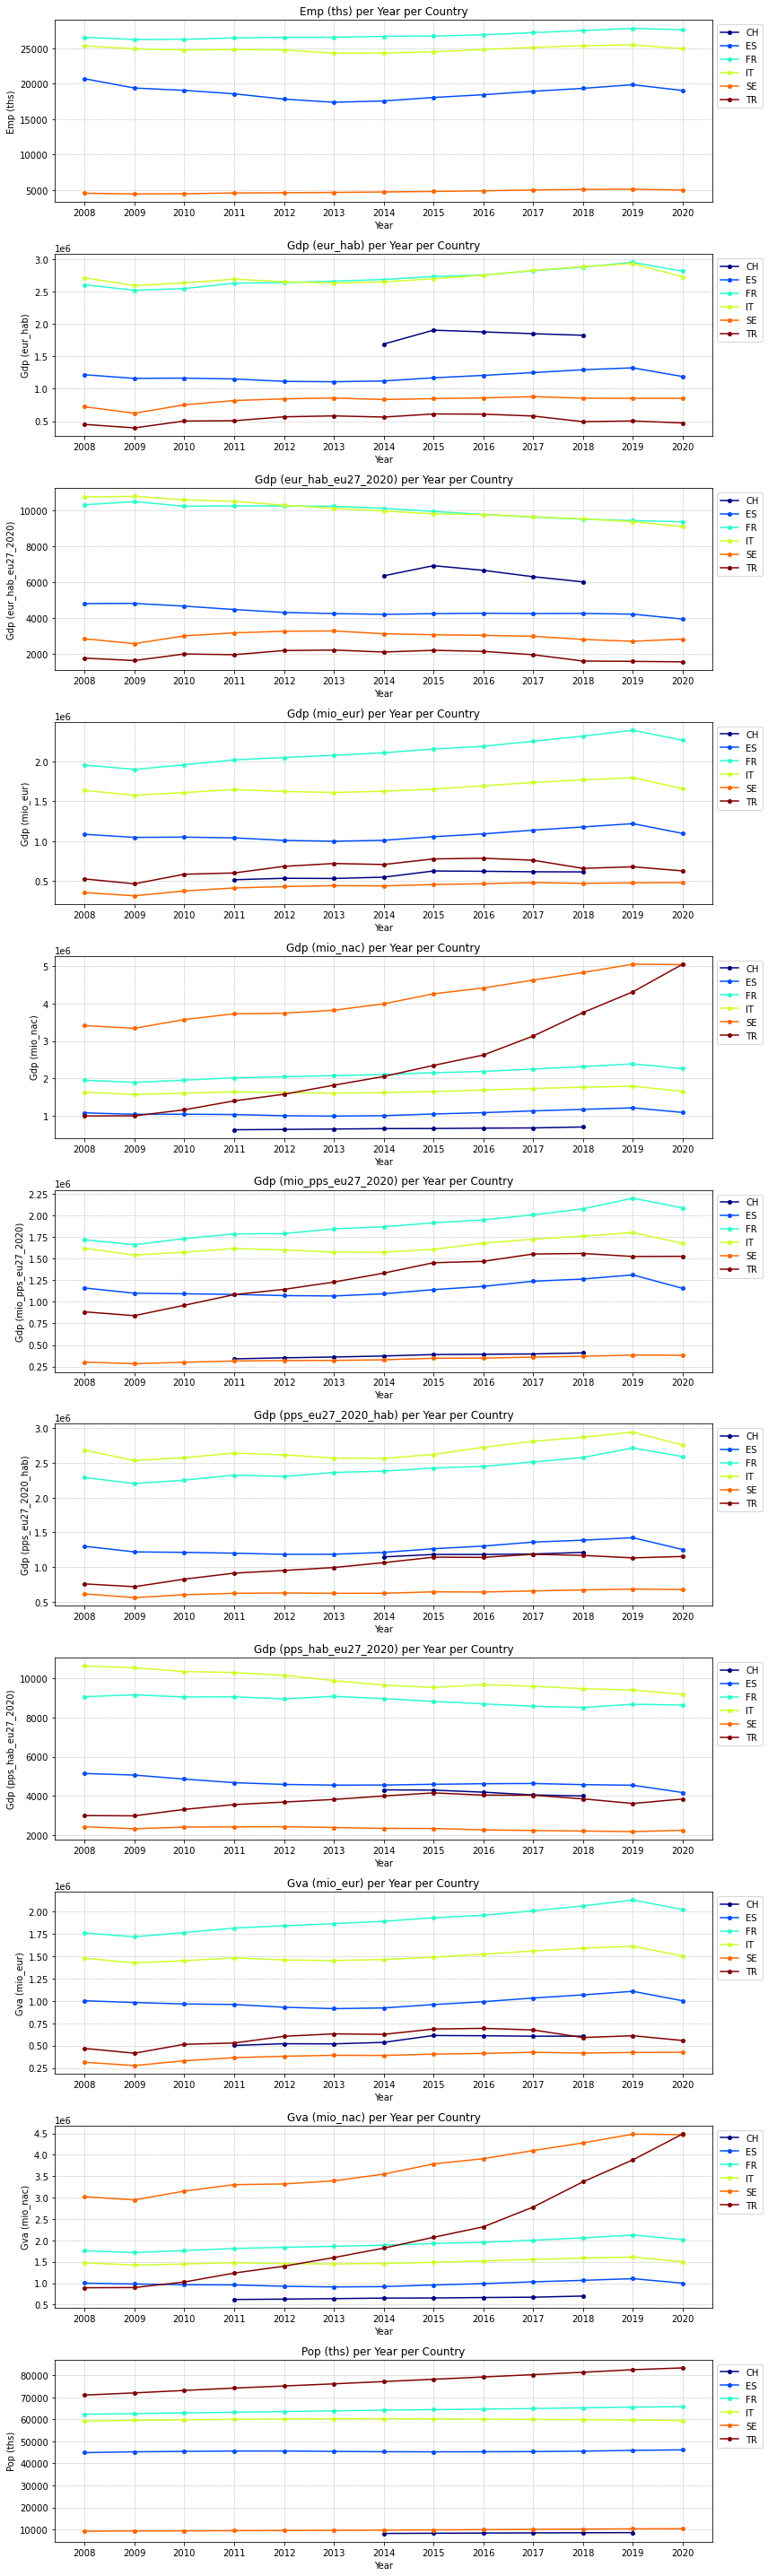

In [23]:
# List of indicators
indicators = [
    'EMP (THS)',
    'GDP (EUR_HAB)',
    'GDP (EUR_HAB_EU27_2020)',
    'GDP (MIO_EUR)',
    'GDP (MIO_NAC)',
    'GDP (MIO_PPS_EU27_2020)',
    'GDP (PPS_EU27_2020_HAB)',
    'GDP (PPS_HAB_EU27_2020)',
    'GVA (MIO_EUR)',
    'GVA (MIO_NAC)',
    'POP (THS)'
]

# Create a list of unique countries for colors
countries = by_year_country['country'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(countries)))  # Get a colormap

# Set up a subplot grid that has 11 rows and 1 column
fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(12, 40))

# Plotting each country's time series for questioncount, answercount, and upvotecount
for idx, metric in enumerate(indicators):
    for i, country in enumerate(countries):
        country_data = by_year_country[by_year_country['country'] == country].sort_values('year')
        axes[idx].plot(country_data['year'], country_data[metric], label=country, color=colors[i], marker='o', markersize=4)

    # Set labels and title for each subplot
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel(metric.capitalize())
    axes[idx].set_title(f'{metric.capitalize()} per Year per Country')
    axes[idx].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[idx].set_xticks(by_year_country['year'].unique())  # Only show integer years on the x-axis
    axes[idx].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

We can observe: 

- We don't have any data on employment for Switzerland and Turkey. 
- The data on GDP, GVA and population is complete for all countries except Switzerland.

We will handle this missing data by finding other data sources for certain countries or filling missing values in a meaningful way. 

### Switzerland Population

The population obtained from the Eurostats data was not complete. We found the complete data for the population by NUTS3 region on the website of the FSA of Switzerland.

**Source:** [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/catalogues-databases/data.assetdetail.26645086.html)

As the population data for the other countries (from Eurostats) is defined as the average annual population, we got the Switzerland population for each canton at the beggining and the end of each year and calculated the average value. These values were coherrent with the ones we had for Switzerland in the Eurostats data.

In the excel file we already mapped the canton to its Nuts3_code.

In [24]:
# Define the columns to read from each file
ch_pop_cols = ['nuts3_code', 'Year', 'POP']

# Read the files with only necessary columns
ch_pop_df = pd.read_csv("Data/Switzerland Population Data.csv", usecols=ch_pop_cols,encoding='unicode_escape')

# Change column names for consistency
ch_pop_df = ch_pop_df.rename(columns = {'Year':'year', 'POP': 'POP (THS)'})

In [25]:
ch_pop_df

,nuts3_code,year,POP (THS)
0,CH040,2007,"1,295.81"
1,CH021,2007,960.94
2,CH061,2007,361.29
3,CH062,2007,34.97
4,CH063,2007,139.93
...,...,...,...
359,CH011,2020,809.93
360,CH012,2020,347.01
361,CH024,2020,176.2
362,CH013,2020,505.24


### Switzerland GDP

The GDP obtained from the Eurostats data was not complete. We found the complete data for the GDP by NUTS3 region on the website of the FSA of Switzerland.

**Source:** [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/national-economy/national-accounts/gross-domestic-product-canton.assetdetail.28405435.html)

**Note:** The data only starts from the year 2008.

In [26]:
# Read the file
ch_gdp_df = pd.read_excel("Data/CH_gdp.xlsx",skiprows = 2)

# Drop unnecessary rows
ch_gdp_df = ch_gdp_df.drop([0])
ch_gdp_df = ch_gdp_df.truncate(after=26)

# Reset index
ch_gdp_df = ch_gdp_df.reset_index()
ch_gdp_df = ch_gdp_df.drop(columns = ['index','2021p'])

# Reshape the DataFrame
ch_gdp_df = pd.melt(ch_gdp_df, id_vars=['Canton'], var_name='year', value_name='GDP (MIO_CHF)')

In [27]:
ch_gdp_df

,Canton,year,GDP (MIO_CHF)
0,Zurich,2008,135763.68806
1,Berne,2008,73222.43163
2,Lucerne,2008,23065.83825
3,Uri,2008,1691.10825
4,Schwyz,2008,8323.13661
...,...,...,...
333,Vaud,2020,56442.69189
334,Valais,2020,19025.75615
335,Neuchâtel,2020,15320.30848
336,Geneva,2020,52015.88663


In [28]:
# Read the mapping file
ch_nuts_map = pd.read_excel("Data/CH_NUTS_map.xlsx")
ch_nuts_map.head()

,nuts3_region,nuts3_code
0,Aargau,CH033
1,Appenzell A. Rh.,CH053
2,Appenzell I. Rh.,CH054
3,Basel-Landschaft,CH032
4,Basel-Stadt,CH031


In [29]:
# Merge on the GDP data
merged_df = pd.merge(ch_gdp_df, ch_nuts_map, left_on=['Canton'], right_on=['nuts3_region'], how='left')
ch_gdp_df = merged_df

# Drop unnecessary columns
ch_gdp_df = ch_gdp_df.drop(columns = ['Canton','nuts3_region'])

ch_gdp_df

,year,GDP (MIO_CHF),nuts3_code
0,2008,135763.68806,CH040
1,2008,73222.43163,CH021
2,2008,23065.83825,CH061
3,2008,1691.10825,CH062
4,2008,8323.13661,CH063
...,...,...,...
333,2020,56442.69189,CH011
334,2020,19025.75615,CH012
335,2020,15320.30848,CH024
336,2020,52015.88663,CH013


When we want to merge the new GDP and GVA data of Switzerland on our main dataset, we have to keep the different currencies in mind.

### Switzerland GVA

The GVA obtained from the Eurostats data was not complete. We found the complete data for the GVA by NUTS3 region on the website of the FSA of Switzerland.

**Source:** [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/national-economy/national-accounts/gross-domestic-product-canton.assetdetail.28405434.html)

**Note:** The data only starts from the year 2008.

In [30]:
# Read the file
ch_gva_df = pd.read_excel("Data/CH_gva_mapped.xlsx")

# Drop the region
ch_gva_df = ch_gva_df.drop(columns = ['nuts3_region'])

# Reshape the DataFrame
ch_gva_df = pd.melt(ch_gva_df, id_vars=['nuts3_code'], var_name='year', value_name='GVA (MIO_CHF)')

ch_gva_df

,nuts3_code,year,GVA (MIO_CHF)
0,CH033,2008,37981.40435
1,CH053,2008,2781.21994
2,CH054,2008,804.48386
3,CH032,2008,17950.68857
4,CH031,2008,29217.83197
...,...,...,...
333,CH062,2020,1958.58102
334,CH012,2020,18596.20347
335,CH011,2020,55082.44085
336,CH066,2020,19551.75653


***GDP and GVA Currency Correction***

The unit for the GDP and GVA data for Switzerland is "Million CHF", whereas the unit for the other countries is "Million EUR". We have to change the Switzerland data to EUR. 

In order to do this, we took the average CHF/EUR exchange rate per year provided by the [ECB Data Portal](https://data.ecb.europa.eu/data/datasets/EXR/EXR.M.CHF.EUR.SP00.A?chart_props=W3sibm9kZUlkIjoiMzIyNjk3IiwicHJvcGVydGllcyI6W3siY29sb3JIZXgiOiIiLCJjb2xvclR5cGUiOiIiLCJjaGFydFR5cGUiOiJsaW5lY2hhcnQiLCJsaW5lU3R5bGUiOiJTb2xpZCIsImxpbmVXaWR0aCI6IjEuNSIsImF4aXNQb3NpdGlvbiI6ImxlZnQiLCJvYnNlcnZhdGlvblZhbHVlIjpmYWxzZSwiZGF0ZXMiOlsiMjAwNy0wMS0wMVQwMDowMDowMC4wMDBaIiwiMjAyMC0xMi0zMVQwMDowMDowMC4wMDBaIl0sImlzVGRhdGEiOnRydWUsIm1vZGlmaWVkVW5pdFR5cGUiOiJub25lIiwieWVhciI6ImRhdGV3aXNlIiwic3RhcnREYXRlIjoiMjAwNy0wMS0wMSIsImVuZERhdGUiOiIyMDIwLTEyLTMxIiwic2V0RGF0ZSI6dHJ1ZSwic2hvd1RhYmxlRGF0YSI6ZmFsc2UsImNoYW5nZU1vZGUiOmZhbHNlLCJzaG93TWVudVN0eWxlQ2hhcnQiOmZhbHNlLCJkaXNwbGF5TW9iaWxlQ2hhcnQiOnRydWUsInNjcmVlblNpemUiOiJtYXgiLCJzY3JlZW5XaWR0aCI6MTQ0MCwic2hvd1RkYXRhIjpmYWxzZSwidHJhbnNmb3JtZWRGcmVxdWVuY3kiOiJ5ZWFybHkiLCJ0cmFuc2Zvcm1lZFVuaXQiOiJub25lIiwiZnJlcXVlbmN5IjoieWVhcmx5IiwidW5pdCI6Im5vbmUiLCJtb2RpZmllZCI6InRydWUiLCJzZXJpZXNLZXkiOiJtb250aGx5Iiwic2hvd3RhYmxlU3RhdGVCZWZvcmVNYXhTY3JlZW4iOmZhbHNlLCJpc2RhdGFjb21wYXJpc29uIjpmYWxzZSwic2VyaWVzRnJlcXVlbmN5IjoieWVhcmx5IiwiaW50aWFsU2VyaWVzRnJlcXVlbmN5IjoibW9udGhseSIsIm1ldGFkYXRhRGVjaW1hbCI6IjQiLCJpc1RhYmxlU29ydGVkIjpmYWxzZSwiaXNZZWFybHlUZGF0YSI6dHJ1ZSwicmVzcG9uc2VEYXRhRW5kRGF0ZSI6IjIwMjMtMTAtMzEiLCJpc2luaXRpYWxDaGFydERhdGEiOnRydWUsImlzRGF0ZXNGcm9tRGF0ZVBpY2tlciI6dHJ1ZSwiZGF0ZVBpY2tlckVuZERhdGUiOiIyMDIwLTEyLTMxIiwiaXNEYXRlUGlja2VyRW5kRGF0ZSI6dHJ1ZSwic2VyaWVza2V5U2V0IjoiRVhSLk0uQ0hGLkVVUi5TUDAwLkF8MTh8bm9uZXx5ZWFybHl8bm9uZXxBbm51YWwiLCJkYXRhc2V0SWQiOiIxOCIsImlzQ2FsbGJhY2siOmZhbHNlLCJpc1NsaWRlclRkYXRhIjpmYWxzZSwiaXNTbGlkZXJEYXRhIjp0cnVlLCJpc0luaXRpYWxDaGFydERhdGFGcm9tR3JhcGgiOnRydWUsImNoYXJ0U2VyaWVzS2V5IjoiRVhSLk0uQ0hGLkVVUi5TUDAwLkEiLCJ0eXBlT2YiOiJkb3duTG9hZCJ9XX1d) and calculated the value in EUR.

In [31]:
# Read the file
ch_eur = pd.read_csv("Data/CH_EUR.csv")

# Drop unnecessary columns
ch_eur = ch_eur.drop(columns = ['DATE'])

# Rename columns
ch_eur = ch_eur.rename(columns = {'TIME PERIOD':'year', 'Swiss franc/Euro (EXR.M.CHF.EUR.SP00.A) - Modified value (Annual)': 'exchange_ratio'})

# Drop years that are outside our time period
ch_eur = ch_eur[(ch_eur.year >2006) & (ch_eur.year <2021)]

ch_eur.head()

,year,exchange_ratio
8,2007,1.6427
9,2008,1.5871
10,2009,1.5099
11,2010,1.3823
12,2011,1.2340


**GDP Correction:**

In [32]:
# Merge the exchange ratio on the GDP data
merged_df = pd.merge(ch_gdp_df, ch_eur, on = 'year', how = 'left')

# Update the values for the GDP data
merged_df['GDP (MIO_EUR)'] = merged_df['GDP (MIO_CHF)'] / merged_df['exchange_ratio']

# Drop unnecessary columns 
merged_df = merged_df.drop(columns = ['GDP (MIO_CHF)', 'exchange_ratio'])

# Overwrite the old GDP dataset
ch_gdp_df = merged_df

In [33]:
ch_gdp_df.head()

,year,nuts3_code,GDP (MIO_EUR)
0,2008,CH040,85541.98731
1,2008,CH021,46135.991198
2,2008,CH061,14533.32383
3,2008,CH062,1065.53352
4,2008,CH063,5244.242083


**GVA Correction:**

In [34]:
# Merge the exchange ratio on the GVA data
merged_df = pd.merge(ch_gva_df, ch_eur, on = 'year', how = 'left')

# Update the values for the GVA data
merged_df['GVA (MIO_EUR)'] = merged_df['GVA (MIO_CHF)'] / merged_df['exchange_ratio']

# Drop unnecessary columns 
merged_df = merged_df.drop(columns = ['GVA (MIO_CHF)', 'exchange_ratio'])

# Overwrite the old GVA dataset
ch_gva_df = merged_df

In [35]:
ch_gva_df.head()

,nuts3_code,year,GVA (MIO_EUR)
0,CH033,2008,23931.324019
1,CH053,2008,1752.391116
2,CH054,2008,506.889207
3,CH032,2008,11310.370216
4,CH031,2008,18409.572157


### Switzerland Employment

The employment obtained from the Eurostats data was not complete. We found data for the employment by NUTS3 region on the website of the FSA of Switzerland.

**Source:** [Federal Statistics Office](https://www.bfs.admin.ch/bfs/en/home/statistics/catalogues-databases/tables.assetdetail.23985083.html)

We select the number of employed persons out of the total population (so not only out of the population aged 15 - 64 years). In the Eurostats data, the employment indicator is defined as thousands persons per region, therefore we have to divide the values by 1000 in order to get the same unit as for the other countries.

**Note:** The data for the years 2007-2009 is missing. The data only starts from the year 2010. Excluded from the statistical basis are persons living in collective households, diplomats and international civil servants and their family members.

In [36]:
# Read the file
ch_emp_df = pd.read_csv("Data/CH_emp.csv", sep = ';')

# Select the relevant rows (only employed persons of total population)
ch_emp_df = ch_emp_df[(ch_emp_df.ERWP == '1') 
                      & (ch_emp_df.ERWL == 'Total') 
                      & (ch_emp_df.POP1564 == 'Total') 
                      & (ch_emp_df.UNIT_MEA ==  'pers') 
                      & (ch_emp_df.GEO != 'CH')
                      & (ch_emp_df.TIME_PERIOD < 2021)]

# Drop unnecessary columns
ch_emp_df = ch_emp_df.drop(columns = ['ERWP','ERWL','POP1564', 'UNIT_MEA', 'OBS_CONFIDENCE', 'OBS_STATUS'])

# Divide population column by 1000 to get the same unit as for the other countries
ch_emp_df['OBS_VALUE'] = ch_emp_df['OBS_VALUE'] / 1000

# Rename columns
ch_emp_df = ch_emp_df.rename(columns = {'TIME_PERIOD':'year','GEO':'nuts3_code', 'OBS_VALUE': 'EMP (THS)'})

# Reset index
ch_emp_df = ch_emp_df.reset_index()
ch_emp_df = ch_emp_df.drop(columns = ['index'])


ch_emp_df

,year,nuts3_code,EMP (THS)
0,2010,CH040,789.980
1,2010,CH021,544.243
2,2010,CH061,213.135
3,2010,CH062,18.534
4,2010,CH063,83.604
...,...,...,...
281,2020,CH011,415.954
282,2020,CH012,176.204
283,2020,CH024,88.907
284,2020,CH013,234.038


### Update the Data on Final Dataset

First we merge all of the newly curated data into one DataFrame:

In [37]:
# Merge all DataFrames on 'nuts3_code' and 'year'
ch_data_new = (ch_pop_df
             .merge(ch_gdp_df, on=['nuts3_code', 'year'], how='left')
             .merge(ch_gva_df, on=['nuts3_code', 'year'], how='left')
             .merge(ch_emp_df, on=['nuts3_code', 'year'], how='left'))

In [38]:
# Rename colums for final merging purposes
ch_data_new = ch_data_new.rename(columns = 
                                 {'POP (THS)':'POP Merge','GDP (MIO_EUR)':'GDP Merge', 'GVA (MIO_EUR)': 'GVA Merge', 'EMP (THS)':'EMP Merge'})

ch_data_new

,nuts3_code,year,POP Merge,GDP Merge,GVA Merge,EMP Merge
0,CH040,2007,"1,295.81",NaN,NaN,NaN
1,CH021,2007,960.94,NaN,NaN,NaN
2,CH061,2007,361.29,NaN,NaN,NaN
3,CH062,2007,34.97,NaN,NaN,NaN
4,CH063,2007,139.93,NaN,NaN,NaN
...,...,...,...,...,...,...
359,CH011,2020,809.93,52735.393712,51464.487387,415.954
360,CH012,2020,347.01,17776.096562,17374.757984,176.204
361,CH024,2020,176.2,14314.032028,13962.970989,88.907
362,CH013,2020,505.24,48599.352172,47384.454508,234.038


In [39]:
ch_data_new.dtypes

nuts3_code     object
year           object
POP Merge      object
GDP Merge      object
GVA Merge     float64
EMP Merge     float64
dtype: object

Now we update the data for Switzerland in our final dataset:

In [40]:
# Make sure that the 'year' column is of the same type in both DataFrames
final_df['year'] = final_df['year'].astype(int)
ch_data_new['year'] = ch_data_new['year'].astype(int)

# Replace 'NaN' string with actual NaN values
ch_data_new.replace('NaN', pd.NA, inplace=True)

# Convert 'POP Merge' from string to float, assuming that the decimal separator is a comma
ch_data_new['POP Merge'] = ch_data_new['POP Merge'].str.replace(',', '').astype(float)

# Merge the data on 'nuts3_code' and 'year'
final_df_updated = final_df.merge(ch_data_new, on=['nuts3_code', 'year'], how='left')

# Update the main dataset with the new values where they are not missing
final_df_updated['POP (THS)'] = final_df_updated['POP Merge'].combine_first(final_df_updated['POP (THS)'])
final_df_updated['GDP (MIO_EUR)'] = final_df_updated['GDP Merge'].combine_first(final_df_updated['GDP (MIO_EUR)'])
final_df_updated['GVA (MIO_EUR)'] = final_df_updated['GVA Merge'].combine_first(final_df_updated['GVA (MIO_EUR)'])
final_df_updated['EMP (THS)'] = final_df_updated['EMP Merge'].combine_first(final_df_updated['EMP (THS)'])

# Drop the merge columns as they are no longer needed
final_df_updated.drop(['POP Merge', 'GDP Merge', 'GVA Merge', 'EMP Merge'], axis=1, inplace=True)

final_df_updated

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,NaN,NaN,24942.455371,NaN,NaN,NaN,NaN,23931.324019,NaN,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,NaN,NaN,25582.147076,NaN,NaN,NaN,NaN,24614.963819,NaN,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,NaN,NaN,28422.11381,NaN,NaN,NaN,NaN,27311.621095,NaN,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,NaN,NaN,32557.042431,39186.33,20892.36,NaN,NaN,31336.257699,38146.50,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,NaN,NaN,33443.246005,39438.95,21505.74,NaN,NaN,32261.320850,38474.47,622.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,41000.0,145.0,18408.07,174304.19,13722.47,30600.0,108.0,16305.800000,154398.00,449.00
5001,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,41300.0,141.0,18787.46,181019.09,14044.57,30900.0,105.0,16657.120000,160493.00,454.99
5002,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,41000.0,135.0,18855.66,193427.07,14793.54,32200.0,106.0,16710.180000,171418.00,460.01
5003,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,40600.0,130.0,18820.58,199292.98,15097.04,32500.0,104.0,16714.730000,176994.00,464.00


Check if there are still missing values for the Switzerland data:

In [41]:
final_df_updated[final_df_updated.country == 'CH'].isnull().sum()

year                         0
nuts3_name                   0
country                      0
questioncount                0
answercount                  0
upvotecount                  0
downvotecount                0
commentcount                 0
nuts3_code                   0
EMP (THS)                   52
GDP (EUR_HAB)              208
GDP (EUR_HAB_EU27_2020)    208
GDP (MIO_EUR)                0
GDP (MIO_NAC)              130
GDP (MIO_PPS_EU27_2020)    130
GDP (PPS_EU27_2020_HAB)    208
GDP (PPS_HAB_EU27_2020)    208
GVA (MIO_EUR)                0
GVA (MIO_NAC)              130
POP (THS)                    0
dtype: int64

We can see:

- There are no missing values left for GDP and GVA
- There are 78 missing values for EMP, because the data only starts from 2010
- There are no missing values left for POP
- There is still the same amount of missing data for the other GDP/GVA indicators, because we didn't update them

The rest of the missing values will be handled by calculating and filling them in a meaningful way. There is still employment data missing for Turkey.

Visualize the changes:

In [42]:
# Read the final datset
df = pd.read_excel(r"FINAL_updated.xlsx")

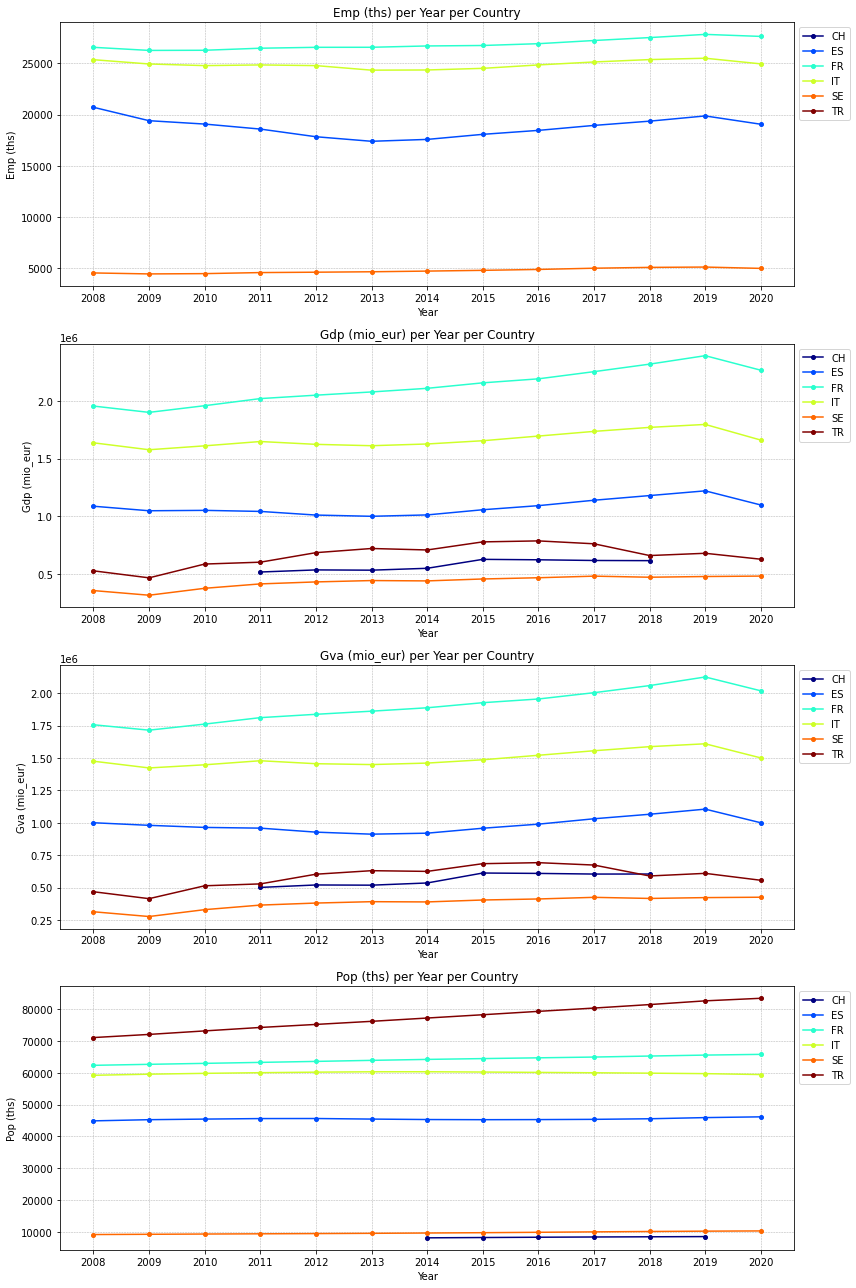

In [43]:
# List of indicators
indicators = [
    'EMP (THS)',
    'GDP (MIO_EUR)',
    'GVA (MIO_EUR)',
    'POP (THS)'
]

# Create a list of unique countries for colors
countries = by_year_country['country'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(countries)))  # Get a colormap

# Set up a subplot grid that has 4 rows and 1 column
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 18))

# Plotting each country's time series for questioncount, answercount, and upvotecount
for idx, metric in enumerate(indicators):
    for i, country in enumerate(countries):
        country_data = by_year_country[by_year_country['country'] == country].sort_values('year')
        axes[idx].plot(country_data['year'], country_data[metric], label=country, color=colors[i], marker='o', markersize=4)

    # Set labels and title for each subplot
    axes[idx].set_xlabel('Year')
    axes[idx].set_ylabel(metric.capitalize())
    axes[idx].set_title(f'{metric.capitalize()} per Year per Country')
    axes[idx].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[idx].set_xticks(by_year_country['year'].unique())  # Only show integer years on the x-axis
    axes[idx].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

We can see that the only data this is still missing is the employment data for Turkey.

### Turkey Employment

The employment data for Turkey was inexistent in the Eurostats dataset. As far as our research went, the only public available data by year is as a total country not by Nuts3 region.  

Source: [Turkish Statistical Institue](https://data.tuik.gov.tr/Kategori/GetKategori?p=istihdam-issizlik-ve-ucret-108&dil=1)

However the granularity of this dataset is at a national level and not nuts3 as desired. For the analysis we used the average value of the year to smooth down the variations along the year.
To distribute the global value down to a NUTS3 region, we used the % distribution of the population per year and nuts3 region. The rationale behind this operation lies in the assumption that employment is distributed across the different regions in the same way population does.

**Points to consider** Primarily, it assumes a uniformity in employment-population ratio across all regions, an assumption which may not hold true across different NUTS 3 regions due to diverse economic structures and variances in labor market dynamics. Nonetheless, the derived regional employment estimates serve as a critical input for the subsequent analytical processes within this thesis, enabling a richer investigation into regional programming density and its correlational factors.

In [44]:
# Read the file
turkey_employment = pd.read_excel("Data/Turkey Employment.xlsx",sheet_name="Population")

# Drop unnecessary columns
turkey_employment = turkey_employment.drop(columns=['POP (THS)', '% Distribution'])

turkey_employment

,year,nuts3_name,nuts3_code,Employment THS
0,2007,Adana,TR621,569.605034
1,2007,Adiyaman,TRC12,165.920215
2,2007,Afyon,TR332,200.011652
3,2007,Agri,TRA21,151.180053
4,2007,Aksaray,TR712,104.113623
...,...,...,...,...
1129,2020,Usak,TR334,118.517486
1130,2020,Van,TRB21,366.168640
1131,2020,Yalova,TR425,87.617151
1132,2020,Yozgat,TR723,134.592323


In [45]:
final_df_updated

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,NaN,NaN,24942.455371,NaN,NaN,NaN,NaN,23931.324019,NaN,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,NaN,NaN,25582.147076,NaN,NaN,NaN,NaN,24614.963819,NaN,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,NaN,NaN,28422.11381,NaN,NaN,NaN,NaN,27311.621095,NaN,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,NaN,NaN,32557.042431,39186.33,20892.36,NaN,NaN,31336.257699,38146.50,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,NaN,NaN,33443.246005,39438.95,21505.74,NaN,NaN,32261.320850,38474.47,622.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,41000.0,145.0,18408.07,174304.19,13722.47,30600.0,108.0,16305.800000,154398.00,449.00
5001,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,41300.0,141.0,18787.46,181019.09,14044.57,30900.0,105.0,16657.120000,160493.00,454.99
5002,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,41000.0,135.0,18855.66,193427.07,14793.54,32200.0,106.0,16710.180000,171418.00,460.01
5003,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,40600.0,130.0,18820.58,199292.98,15097.04,32500.0,104.0,16714.730000,176994.00,464.00


Wether to use the data based on the asumptions that the distribution of employment goes according to the population we must first statistically confirm if this also occurs for the other countries. If we can prove this then the turkey_employment can be useful to infer further analises.

In [46]:
#Load the data to analize the distribution of population and employment
employment_distribution = final_df_updated[['year', 'nuts3_name', 'country', 'EMP (THS)', 'POP (THS)']]

#Drop Turkey because its the 
employment_distribution = employment_distribution[final_df_updated['country'] != 'TR']

# Drop rows where there is a NaN in either 'POP (THS)' or 'EMP (THS)'
employment_distribution = employment_distribution.dropna(subset=['POP (THS)', 'EMP (THS)'])

# Group by country and year to calculate total employment and population
country_year_totals = employment_distribution.groupby(['country', 'year']).agg({'EMP (THS)': 'sum', 'POP (THS)': 'sum'}).reset_index()

# Merge the totals back with the original DataFrame to have everything in one place
employment_distribution = employment_distribution.merge(country_year_totals, on=['country', 'year'], suffixes=('', '_total'))

# Calculate the percentage of employment and population for each NUTS3 region
employment_distribution['EMP_Percent'] = (employment_distribution['EMP (THS)'] / employment_distribution['EMP (THS)_total']) * 100
employment_distribution['POP_Percent'] = (employment_distribution['POP (THS)'] / employment_distribution['POP (THS)_total']) * 100

# Calculate the absolute difference between employment and population percentages
employment_distribution['Percentage_Difference'] = abs(employment_distribution['EMP_Percent'] - employment_distribution['POP_Percent'])

# Sort by this new difference column to see the regions with the largest discrepancies
employment_distribution_sorted = employment_distribution.sort_values(by='Percentage_Difference', ascending=False)

# Print the sorted DataFrame to inspect the results
print(employment_distribution_sorted[['year', 'nuts3_name', 'country', 'EMP_Percent', 'POP_Percent', 'Percentage_Difference']])

employment_distribution_sorted.to_csv('employment_population_distribution.csv', index=False)


      year     nuts3_name country  EMP_Percent  POP_Percent  \
2804  2019          Paris      FR     7.440612     3.307098   
2708  2018          Paris      FR     7.437974     3.340760   
2900  2020          Paris      FR     7.354033     3.271900   
2612  2017          Paris      FR     7.354559     3.369647   
2516  2016          Paris      FR     7.324522     3.390840   
...    ...            ...     ...          ...          ...   
1468  2019  Ascoli Piceno      IT     0.346313     0.346062   
654   2011        Livorno      IT     0.568758     0.568913   
216   2018         Glarus      CH     0.474391     0.474258   
3370  2016      Castellón      ES     1.257903     1.257957   
3616  2020        Segovia      ES     0.332667     0.332707   

      Percentage_Difference  
2804               4.133514  
2708               4.097213  
2900               4.082132  
2612               3.984912  
2516               3.933682  
...                     ...  
1468               0.000250  
654

In [47]:
# Find the maximum and minimum percentage difference
max_diff = employment_distribution_sorted['Percentage_Difference'].max()
min_diff = employment_distribution_sorted['Percentage_Difference'].min()

# Print the maximum and minimum percentage difference
print(f"Maximum Percentage Difference: {max_diff}")
print(f"Minimum Percentage Difference: {min_diff}")


Maximum Percentage Difference: 4.133513943065657
Minimum Percentage Difference: 3.967033113411178e-05


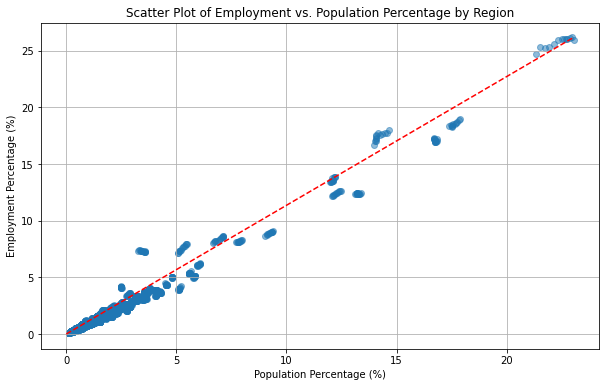

In [48]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.scatter(employment_distribution_sorted['POP_Percent'], employment_distribution_sorted['EMP_Percent'], alpha=0.5)

# A line of equality. Points above this line have higher employment % compared to population %, and vice versa.
plt.plot([0, max(employment_distribution_sorted['POP_Percent'])], [0, max(employment_distribution_sorted['EMP_Percent'])], 'r--')

plt.title('Scatter Plot of Employment vs. Population Percentage by Region')
plt.xlabel('Population Percentage (%)')
plt.ylabel('Employment Percentage (%)')
plt.grid(True)
plt.show()

By observing the relationship between the distribution of employment and population across the different nuts_3 regions we can infer that there is a high positive correlation which suggest that generally speaking, those regions with a high population density tend to have high employment rates.
The red dashed line represents the line of equality which means that its the point where both distributions are equal. As observed, most of the points lay very close to the line.

Further statistical analysis will be performed to help us determine this in a numerical way rather than just visual.

       EMP_Percent  POP_Percent
count  3900.000000  3900.000000
mean      1.615385     1.615385
std       2.732053     2.501763
min       0.112497     0.117224
25%       0.454738     0.485204
50%       0.805240     0.874999
75%       1.786619     1.808329
max      26.164944    23.039035


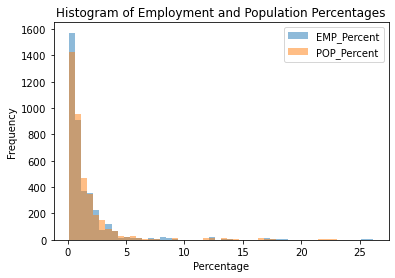

Pearson Correlation Coefficient: 0.9889957296831592
                            OLS Regression Results                            
Dep. Variable:            EMP_Percent   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 1.742e+05
Date:                Wed, 08 Nov 2023   Prob (F-statistic):               0.00
Time:                        00:11:09   Log-Likelihood:                -2000.5
No. Observations:                3900   AIC:                             4005.
Df Residuals:                    3898   BIC:                             4017.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [49]:
# Descriptive Statistics
print(employment_distribution[['EMP_Percent', 'POP_Percent']].describe())


# Histogram Comparison
employment_distribution[['EMP_Percent', 'POP_Percent']].plot(kind='hist', alpha=0.5, bins=50)
plt.title('Histogram of Employment and Population Percentages')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.show()

# Correlation Coefficient
correlation, _ = pearsonr(employment_distribution['EMP_Percent'], employment_distribution['POP_Percent'])
print('Pearson Correlation Coefficient:', correlation)

# Simple Linear Regression
import statsmodels.api as sm

X = employment_distribution['POP_Percent']
y = employment_distribution['EMP_Percent']
X = sm.add_constant(X) # adding a constant

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print_model = model.summary()
print(print_model)

**The Pearson value** of  0.9889957296831592 suggests a very high positive correlation between both indicators, in other ways, as the population increases in a nuts3_region, the employment rate tends to increase linearly and viceversa.

Additionally from the histogram there appears to be a lot of overlap between the two distributions, suggesting that in many regions, the distribution of employment aligns well with the distribution of the population. 

In [50]:
# Group the data by 'country' and count the NaN values in 'EMP (THS)' for each country
nan_count_by_country = final_df_updated.groupby('country')['EMP (THS)'].apply(lambda x: x.isnull().sum())

# Print the count of NaN values for 'EMP (THS)' for each country
print(nan_count_by_country)

country
CH      52
ES       0
FR       0
IT       0
SE       0
TR    1053
Name: EMP (THS), dtype: int64


In [51]:
final_df_updated

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,NaN,NaN,24942.455371,NaN,NaN,NaN,NaN,23931.324019,NaN,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,NaN,NaN,25582.147076,NaN,NaN,NaN,NaN,24614.963819,NaN,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,NaN,NaN,28422.11381,NaN,NaN,NaN,NaN,27311.621095,NaN,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,NaN,NaN,32557.042431,39186.33,20892.36,NaN,NaN,31336.257699,38146.50,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,NaN,NaN,33443.246005,39438.95,21505.74,NaN,NaN,32261.320850,38474.47,622.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,41000.0,145.0,18408.07,174304.19,13722.47,30600.0,108.0,16305.800000,154398.00,449.00
5001,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,41300.0,141.0,18787.46,181019.09,14044.57,30900.0,105.0,16657.120000,160493.00,454.99
5002,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,41000.0,135.0,18855.66,193427.07,14793.54,32200.0,106.0,16710.180000,171418.00,460.01
5003,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,40600.0,130.0,18820.58,199292.98,15097.04,32500.0,104.0,16714.730000,176994.00,464.00


In [52]:
# Rename the 'Employment THS' column in turkey_employment to match 'EMP (THS)' in final_df_updated
turkey_employment = turkey_employment.rename(columns={'Employment THS': 'EMP (THS)'})

# Create a subset of turkey_employment with only the required columns for the merge
turkey_employment_subset = turkey_employment[['nuts3_code', 'year', 'EMP (THS)']]

# Merge both df, using the subset with only the columns we need from turkey_employment
final_df_updated = final_df_updated.merge(turkey_employment_subset, on=['nuts3_code', 'year'], how='left', suffixes=('', '_tr'), indicator=True)

# Where 'EMP (THS)' is NaN and the country is TR, fill it with the value from turkey_employment
final_df_updated.loc[(final_df_updated['country'] == 'TR') & (final_df_updated['EMP (THS)'].isnull()), 'EMP (THS)'] = final_df_updated['EMP (THS)_tr']

# Drop the temporary '_tr' column as it is no longer needed
final_df_updated.drop(columns=['EMP (THS)_tr'], inplace=True)

# Drop the '_merge' column as it is no longer needed
final_df_updated.drop(columns=['_merge'], inplace=True)


In [53]:
# Group the data by 'country' and count the NaN values in 'EMP (THS)' for each country
nan_count_by_country = final_df_updated.groupby('country')['EMP (THS)'].apply(lambda x: x.isnull().sum())

# Print the count of NaN values for 'EMP (THS)' for each country
print(nan_count_by_country)

country
CH    52
ES     0
FR     0
IT     0
SE     0
TR     0
Name: EMP (THS), dtype: int64


In [54]:
# Save the new dataframe to an Excel file
final_df_updated.to_excel("FINAL_updated.xlsx", index=False)

In [55]:
final_df_updated

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,NaN,NaN,24942.455371,NaN,NaN,NaN,NaN,23931.324019,NaN,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,NaN,NaN,25582.147076,NaN,NaN,NaN,NaN,24614.963819,NaN,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,NaN,NaN,28422.11381,NaN,NaN,NaN,NaN,27311.621095,NaN,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,NaN,NaN,32557.042431,39186.33,20892.36,NaN,NaN,31336.257699,38146.50,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,NaN,NaN,33443.246005,39438.95,21505.74,NaN,NaN,32261.320850,38474.47,622.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,41000.0,145.0,18408.07,174304.19,13722.47,30600.0,108.0,16305.800000,154398.00,449.00
5001,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,41300.0,141.0,18787.46,181019.09,14044.57,30900.0,105.0,16657.120000,160493.00,454.99
5002,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,41000.0,135.0,18855.66,193427.07,14793.54,32200.0,106.0,16710.180000,171418.00,460.01
5003,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,40600.0,130.0,18820.58,199292.98,15097.04,32500.0,104.0,16714.730000,176994.00,464.00
